In [ ]:
# naive approach
# comparing all places among each other (inefficient)
################################################################

places['keep'] = False

counter = 0
i = 0
merge_distance = 0.017
for l, place in places.iterrows():
    for k, other in places.iterrows():
        if (
            haversine_np(place.lon, place.lat, other.lon, other.lat) < merge_distance
            and place.id != other.id
        ):
            # print(l,k)
            places.loc[l, "keep"] = True
            places.loc[k, "keep"] = True
            counter += 1
    i += 1
    if i % 100 == 0:
        print(i, counter)

counter
close = places[places.keep]

# choose parameters

## Plot # of places to be merged dependent on threshold

In [ ]:
# TODO put code from above into function an run the experiment for different thresholds here
merged_spots = {}

for threshold in range(2, 100, 2):
    points = pd.read_csv("german_points.csv", index_col=0)
    places = places_from_points(points)
    num_before = len(places)
    places = gpd.GeoDataFrame(
        places, geometry=gpd.points_from_xy(places.lon, places.lat), crs="EPSG:4326"
    )

    # calculate again because places are changed now
    X = np.array(places[["lon", "lat"]])
    M = pairwise_distances(X, X, metric=haversine, n_jobs=-1)

    clustering = AgglomerativeClustering(
        n_clusters=None,
        linkage="single",
        compute_distances=True,
        affinity="precomputed",
        distance_threshold=threshold / 1000,
    )
    clustering.fit(M)

    # !!! are cluster distances in meter here?
    merge_threshold = threshold

    close_links = clustering.children_[clustering.distances_ < merge_threshold / 1000]

    # establish tree of spots
    # each subtree contains spots that are sufficiently close to each other
    a = [0] * 2 * len(places)
    root = Node("root")

    ii = itertools.count(len(places))
    for x in close_links:
        num = next(ii)
        a[num] = Node(num, parent=root)
        if x[0] < len(places):
            a[x[0]] = Node(x[0], parent=a[num])
        else:
            a[x[0]].parent = a[num]

        if x[1] < len(places):
            a[x[1]] = Node(x[1], parent=a[num])
        else:
            a[x[1]].parent = a[num]

    # find the clusters
    clusters = []
    for subtree in root.children:
        cluster = []
        for leaf in subtree.leaves:
            cluster.append(leaf.name)
        clusters.append(cluster)

    # merge points
    for cluster in clusters:
        merged_spot = places.iloc[cluster].geometry.unary_union.centroid
        lat = merged_spot.y
        lon = merged_spot.x

        for spot in cluster:
            spot = places.iloc[spot]
            points.loc[
                (points.lat == spot.lat) & (points.lon == spot.lon), ["lat", "lon"]
            ] = [lat, lon]

    # rerun fetching the places
    places = places_from_points(points)
    num_after = len(places)
    merged_spots[threshold] = num_before - num_after

Threshold 2 reduced spots from 2745 to 2743
Threshold 4 reduced spots from 2745 to 2741
Threshold 6 reduced spots from 2745 to 2737
Threshold 8 reduced spots from 2745 to 2734
Threshold 10 reduced spots from 2745 to 2730
Threshold 12 reduced spots from 2745 to 2718
Threshold 14 reduced spots from 2745 to 2714
Threshold 16 reduced spots from 2745 to 2706
Threshold 18 reduced spots from 2745 to 2704
Threshold 20 reduced spots from 2745 to 2702
Threshold 22 reduced spots from 2745 to 2696
Threshold 24 reduced spots from 2745 to 2694
Threshold 26 reduced spots from 2745 to 2690
Threshold 28 reduced spots from 2745 to 2682
Threshold 30 reduced spots from 2745 to 2675
Threshold 32 reduced spots from 2745 to 2672
Threshold 34 reduced spots from 2745 to 2660
Threshold 36 reduced spots from 2745 to 2656
Threshold 38 reduced spots from 2745 to 2648
Threshold 40 reduced spots from 2745 to 2641
Threshold 42 reduced spots from 2745 to 2634
Threshold 44 reduced spots from 2745 to 2633
Threshold 46 r

In [ ]:
with open('file.txt', 'w') as file:
     file.write(json.dumps(merged_spots)) # use `json.loads` to do the reverse


In [ ]:
merged_spots = json.loads(open('file.txt').read())

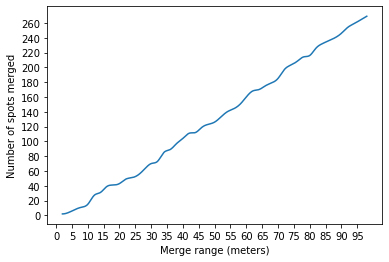

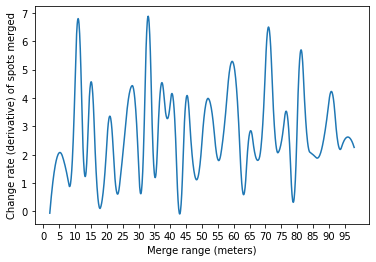

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

args = np.array(list(merged_spots.keys()))
args = args.astype("float64")
values = np.array(list(merged_spots.values()))
values = values.astype("float64")

xnew = np.linspace(args.min(), args.max(), 1000)

spl = make_interp_spline(args, values, k=3)  # type: BSpline

values_smooth = spl(xnew)
plt.plot(xnew, values_smooth)
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 270, 20))
plt.xlabel("Merge range (meters)")
plt.ylabel("Number of spots merged")
plt.show()

derivative_spl = spl.derivative()
values_derivative = derivative_spl(xnew)
plt.plot(xnew, values_derivative)
plt.xticks(np.arange(0, 100, 5))
plt.xlabel("Merge range (meters)")
plt.ylabel("Change rate (derivative) of spots merged")
plt.show()